<a href="https://colab.research.google.com/github/quantumalaviya/Predicting-Planetary-Albedo/blob/main/Messenger_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Task 1</h1>

Mounting drive to load the Messenger data which was pulled from github and uploaded prior to starting the project.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

ModuleNotFoundError: ignored

Import relevant libraries

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import seaborn

In [ ]:
!ls gdrive/MyDrive/Messenger/Moon

Albedo_Map.csv	LPFe_Map.csv  LPK_Map.csv  LPTh_Map.csv  LPTi_Map.csv


Load data as numpy matrices and process for training

In [ ]:
albedo = np.genfromtxt('gdrive/MyDrive/Messenger/Moon/Albedo_Map.csv', delimiter=',')
fe = np.genfromtxt('gdrive/MyDrive/Messenger/Moon/LPFe_Map.csv', delimiter=',')
K = np.genfromtxt('gdrive/MyDrive/Messenger/Moon/LPK_Map.csv', delimiter=',')
th = np.genfromtxt('gdrive/MyDrive/Messenger/Moon/LPTh_Map.csv', delimiter=',')
ti = np.genfromtxt('gdrive/MyDrive/Messenger/Moon/LPTi_Map.csv', delimiter=',')

In [ ]:
X = [fe[:, :360][np.newaxis, :, :, np.newaxis],K[:, :360][np.newaxis, :, :, np.newaxis],th[:, :360][np.newaxis, :, :, np.newaxis],ti[:, :360][np.newaxis, :, :, np.newaxis]]
y = albedo[:, :360][np.newaxis, :, :, np.newaxis]
X_train = [fe[:, 360:][np.newaxis, :, :, np.newaxis],K[:, 360:][np.newaxis, :, :, np.newaxis],th[:, 360:][np.newaxis, :, :, np.newaxis],ti[:, 360:][np.newaxis, :, :, np.newaxis]]
y_train = albedo[:, 360:][np.newaxis, :, :, np.newaxis]

Import ML libraries and generate model. This model is a modified unet with 4 different inputs for different metals. I train it in two settings, standalone and as a pix2pix GAN (using a patchGAN discriminator).

In [ ]:
import tensorflow as tf
from keras import Input, Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, ReLU, Dropout, Layer, LeakyReLU, Activation
from keras.optimizers import Adam

def block(input):
    conv1 = Conv2D(16, (3,3), padding = 'same')(input)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(16, (3,3), padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    
    maxpool1 = MaxPooling2D((2,2))(conv1)
    maxpool1 = Dropout(0.5)(maxpool1)
    
    conv2 = Conv2D(32, (3,3), padding = 'same')(maxpool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    conv2 = Conv2D(32, (3,3), padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    maxpool2 = MaxPooling2D((2,2))(conv2)  
    maxpool2 = Dropout(0.5)(maxpool2)
    
    conv3 = Conv2D(64, (3,3), padding = 'same')(maxpool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    conv3 = Conv2D(64, (3,3), padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)
    
    maxpool3 = MaxPooling2D((2,2))(conv3)
    maxpool3 = Dropout(0.5)(maxpool3)
    
    conv4 = Conv2D(128, (3,3), padding = 'same')(maxpool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(128, (3,3), padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)

    return conv1, conv2, conv3, conv4

def modUnet(Shape):
    input1 = Input(shape = Shape)
    input2 = Input(shape = Shape)
    input3 = Input(shape = Shape)
    input4 = Input(shape = Shape)

    c11, c21, c31, c41 = block(input1)
    c12, c22, c32, c42 = block(input2)
    c13, c23, c33, c43 = block(input3)
    c14, c24, c34, c44 = block(input4)

    conv4 = concatenate([c41, c42, c43, c44])

    up2 = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same')(conv4)
    up2 = concatenate([up2, c31, c32, c33, c34])
    up2 = Dropout(0.5)(up2)
    
    up2 = Conv2D(64, (3,3), padding = 'same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2)
    up2 = Conv2D(64, (3,3), padding = 'same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = ReLU()(up2) 
    
    
    up3 = Conv2DTranspose(32, (3,3), strides = (2,2), padding = 'same')(up2)
    up3 = concatenate([up3, c21, c22, c23, c24])
    up3 = Dropout(0.5)(up3)
    
    up3 = Conv2D(32, (3,3), padding = 'same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = ReLU()(up3)
    up3 = Conv2D(32, (3,3), padding = 'same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = ReLU()(up3) 
    
    
    up4 = Conv2DTranspose(16, (3,3), strides = (2,2), padding = 'same')(up3)
    up4 = concatenate([up4, c11, c12, c13, c14])
    
    up4 = Conv2D(16, (3,3), padding = 'same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = ReLU()(up4)
    up4 = Conv2D(16, (3,3), padding = 'same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = ReLU()(up4)
    
    output = Conv2D(1, (1, 1), activation='sigmoid') (up4)

    model = Model([input1, input2, input3, input4], output)

    return model  

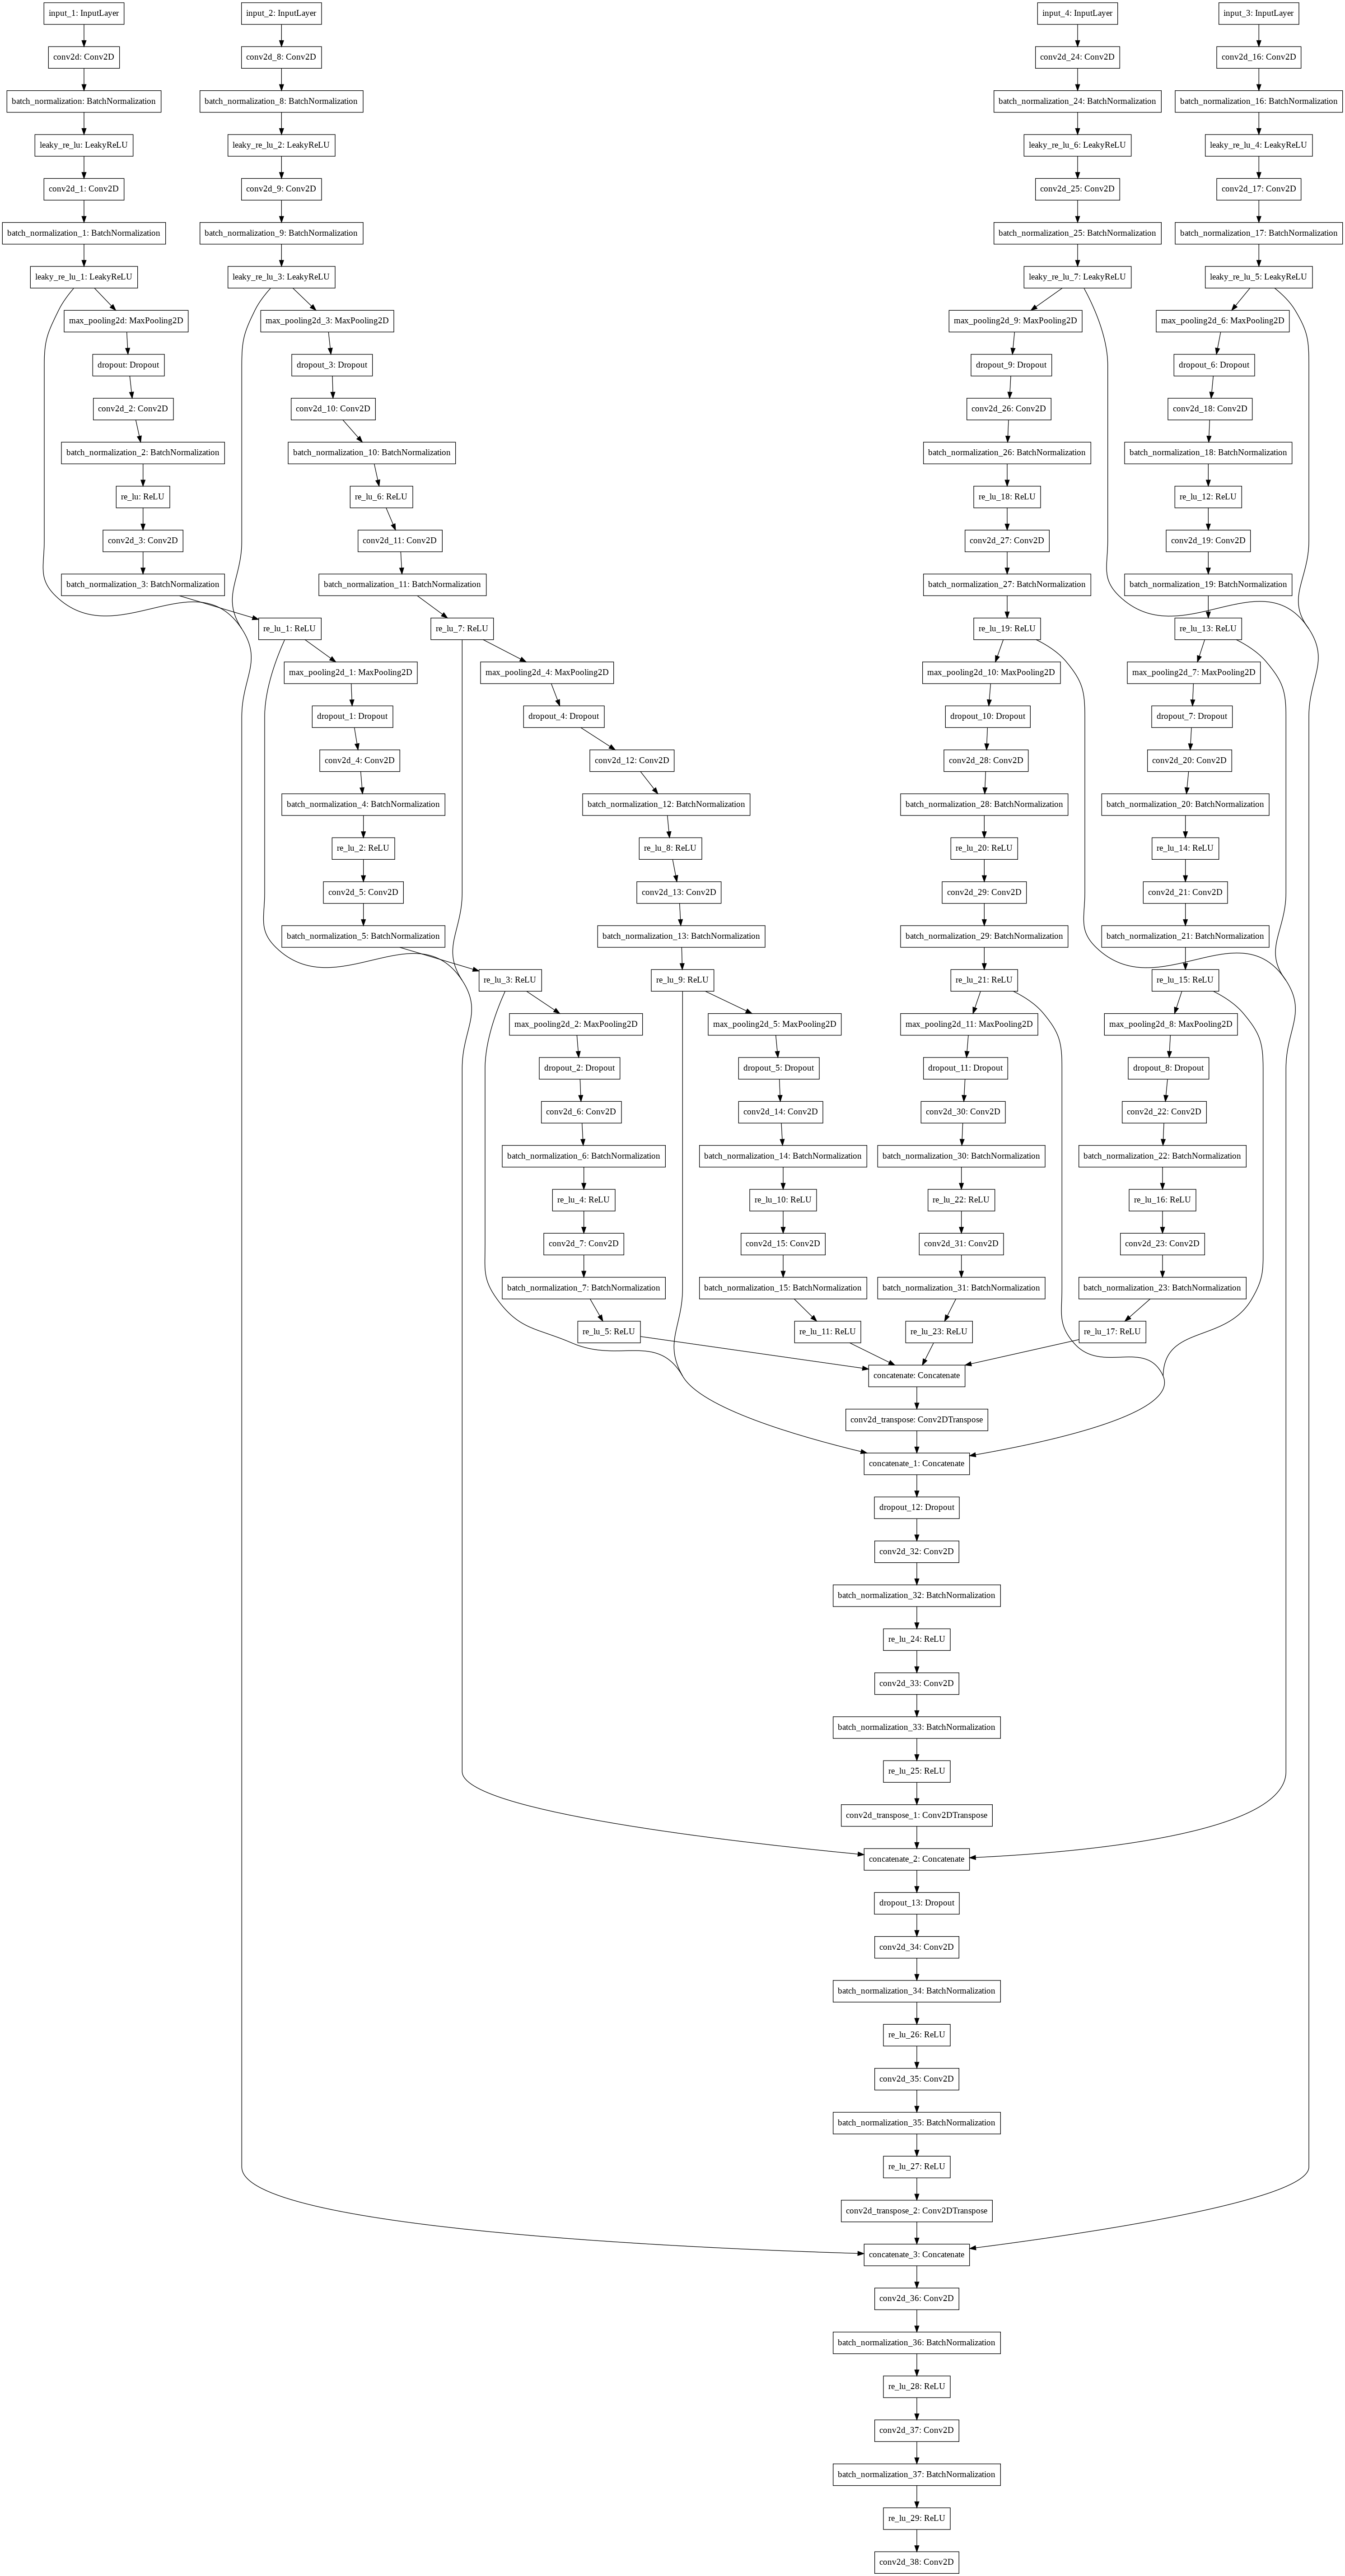

In [ ]:
tf.keras.utils.plot_model(modUnet((200,200,3)))

This is the PatchGAN discriminator. I have made it of a significantly smaller capacity to keep the GAN stable and to get satisfactory results.

In [ ]:
def discriminator(image_shape):
	input1 = Input(shape=image_shape)
	input2 = Input(shape=image_shape)
 
	merged = concatenate([input1, input2])
 
	x = Conv2D(16, (4,4), strides=(2,2), padding='same')(merged)
	x = LeakyReLU(alpha=0.2)(x)
 
	x = Conv2D(1, (4,4), padding='same')(x)
	out = Activation('sigmoid')(x)
 
	model = Model([input1, input2], out)

	opt = Adam(2e-4)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Here, the two models are combined to form a GAN. 

In [ ]:
def gan(gen, dis, Shape = ((360,360,1))):
  for layer in dis.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  input1 = Input(shape=Shape)
  input2 = Input(shape=Shape)
  input3 = Input(shape=Shape)
  input4 = Input(shape=Shape)
  input5 = Input(shape=Shape)
 
  gen_out = gen([input1,input2,input3,input4])
  dis_out = dis([input5, gen_out])
  model = Model([input1, input2, input3, input4, input5], [dis_out, gen_out])
 
  opt = Adam(lr=2e-4)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer = opt)
  
  return model

Making the models

In [ ]:
gen = modUnet((360,360,1))
#gen.summary()

In [ ]:
dis = discriminator((360,360,1))
#dis.summary()

In [ ]:
g = gan(gen, dis)
#g.summary()

Helps visualize (and potentially save) the gan outputs while training

In [ ]:
def summarize_performance(step, gen, X):
	cv2_imshow(np.squeeze(gen.predict(X))*255)
	filename = 'model_%06d.h5' % (step+1)
	#gen.save(filename)

This block will train the GAN for 2500 epochs.

0
d1[0.688] d2[0.731] g[0.821]
1
d1[0.685] d2[0.701] g[0.813]
2
d1[0.685] d2[0.702] g[0.806]
3
d1[0.685] d2[0.704] g[0.800]
4
d1[0.684] d2[0.705] g[0.795]
5
d1[0.684] d2[0.706] g[0.790]
6
d1[0.684] d2[0.707] g[0.786]
7
d1[0.684] d2[0.708] g[0.783]
8
d1[0.684] d2[0.709] g[0.779]
9


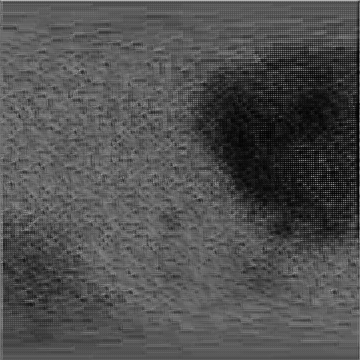

d1[0.684] d2[0.709] g[0.776]
10
d1[0.685] d2[0.710] g[0.773]
11
d1[0.685] d2[0.710] g[0.770]
12
d1[0.685] d2[0.710] g[0.767]
13
d1[0.685] d2[0.709] g[0.764]
14
d1[0.685] d2[0.709] g[0.762]
15
d1[0.685] d2[0.708] g[0.759]
16
d1[0.685] d2[0.708] g[0.756]
17
d1[0.685] d2[0.707] g[0.753]
18
d1[0.686] d2[0.706] g[0.751]
19


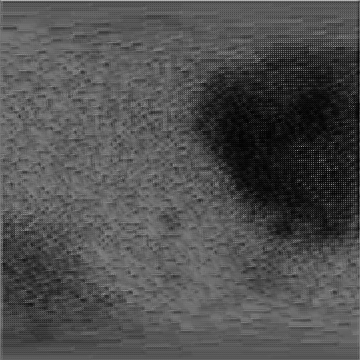

d1[0.686] d2[0.705] g[0.748]
20
d1[0.686] d2[0.704] g[0.746]
21
d1[0.686] d2[0.703] g[0.744]
22
d1[0.686] d2[0.702] g[0.742]
23
d1[0.686] d2[0.702] g[0.740]
24
d1[0.686] d2[0.701] g[0.738]
25
d1[0.687] d2[0.701] g[0.737]
26
d1[0.687] d2[0.701] g[0.735]
27
d1[0.687] d2[0.701] g[0.734]
28
d1[0.687] d2[0.701] g[0.732]
29


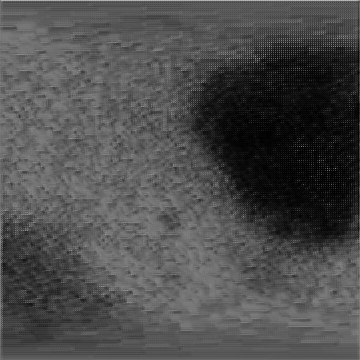

d1[0.687] d2[0.701] g[0.731]
30
d1[0.687] d2[0.701] g[0.730]
31
d1[0.687] d2[0.701] g[0.729]
32
d1[0.687] d2[0.701] g[0.727]
33
d1[0.687] d2[0.701] g[0.726]
34
d1[0.687] d2[0.700] g[0.725]
35
d1[0.688] d2[0.699] g[0.724]
36
d1[0.688] d2[0.699] g[0.724]
37
d1[0.688] d2[0.698] g[0.723]
38
d1[0.688] d2[0.697] g[0.722]
39


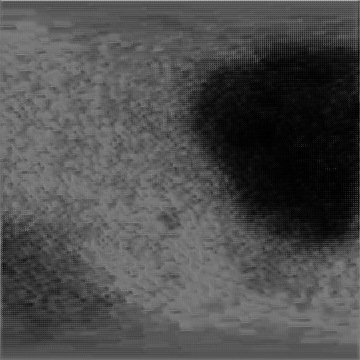

d1[0.688] d2[0.697] g[0.721]
40
d1[0.688] d2[0.696] g[0.721]
41
d1[0.688] d2[0.696] g[0.720]
42
d1[0.688] d2[0.696] g[0.720]
43
d1[0.688] d2[0.696] g[0.719]
44
d1[0.688] d2[0.696] g[0.719]
45
d1[0.688] d2[0.696] g[0.718]
46
d1[0.688] d2[0.696] g[0.718]
47
d1[0.689] d2[0.696] g[0.718]
48
d1[0.689] d2[0.696] g[0.717]
49


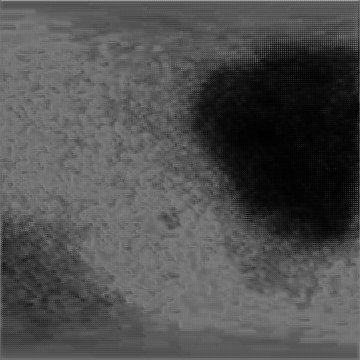

d1[0.689] d2[0.696] g[0.717]
50
d1[0.689] d2[0.696] g[0.717]
51
d1[0.689] d2[0.696] g[0.717]
52
d1[0.689] d2[0.696] g[0.716]
53
d1[0.689] d2[0.696] g[0.716]
54
d1[0.689] d2[0.696] g[0.716]
55
d1[0.689] d2[0.696] g[0.716]
56
d1[0.689] d2[0.696] g[0.716]
57
d1[0.690] d2[0.696] g[0.715]
58
d1[0.690] d2[0.696] g[0.715]
59


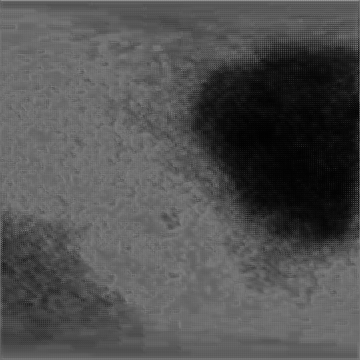

d1[0.690] d2[0.696] g[0.715]
60
d1[0.690] d2[0.696] g[0.715]
61
d1[0.690] d2[0.696] g[0.715]
62
d1[0.690] d2[0.696] g[0.715]
63
d1[0.690] d2[0.696] g[0.715]
64
d1[0.690] d2[0.696] g[0.715]
65
d1[0.691] d2[0.696] g[0.715]
66
d1[0.691] d2[0.696] g[0.714]
67
d1[0.691] d2[0.696] g[0.714]
68
d1[0.691] d2[0.696] g[0.714]
69


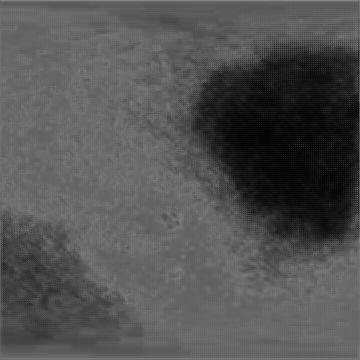

d1[0.691] d2[0.696] g[0.714]
70
d1[0.691] d2[0.696] g[0.714]
71
d1[0.691] d2[0.696] g[0.714]
72
d1[0.691] d2[0.696] g[0.714]
73
d1[0.692] d2[0.696] g[0.714]
74
d1[0.692] d2[0.696] g[0.714]
75
d1[0.692] d2[0.696] g[0.714]
76
d1[0.692] d2[0.696] g[0.714]
77
d1[0.692] d2[0.695] g[0.714]
78
d1[0.692] d2[0.695] g[0.714]
79


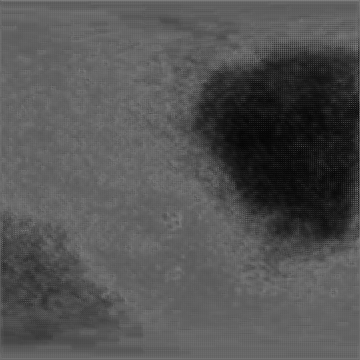

d1[0.692] d2[0.695] g[0.714]
80
d1[0.692] d2[0.695] g[0.714]
81
d1[0.692] d2[0.695] g[0.714]
82
d1[0.693] d2[0.695] g[0.714]
83
d1[0.693] d2[0.695] g[0.714]
84
d1[0.693] d2[0.694] g[0.714]
85
d1[0.693] d2[0.694] g[0.714]
86
d1[0.693] d2[0.694] g[0.714]
87
d1[0.693] d2[0.694] g[0.714]
88
d1[0.693] d2[0.694] g[0.714]
89


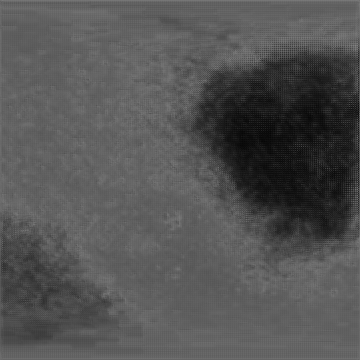

d1[0.693] d2[0.693] g[0.714]
90
d1[0.693] d2[0.693] g[0.715]
91
d1[0.693] d2[0.693] g[0.715]
92
d1[0.693] d2[0.693] g[0.715]
93
d1[0.693] d2[0.693] g[0.715]
94
d1[0.694] d2[0.692] g[0.715]
95
d1[0.694] d2[0.692] g[0.715]
96
d1[0.694] d2[0.692] g[0.715]
97
d1[0.694] d2[0.692] g[0.715]
98
d1[0.694] d2[0.691] g[0.715]
99


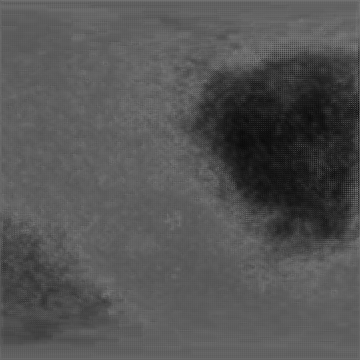

d1[0.694] d2[0.691] g[0.715]
100
d1[0.694] d2[0.691] g[0.715]
101
d1[0.695] d2[0.691] g[0.716]
102
d1[0.695] d2[0.690] g[0.716]
103
d1[0.695] d2[0.690] g[0.716]
104
d1[0.695] d2[0.690] g[0.716]
105
d1[0.695] d2[0.690] g[0.716]
106
d1[0.696] d2[0.689] g[0.716]
107
d1[0.696] d2[0.689] g[0.717]
108
d1[0.696] d2[0.689] g[0.717]
109


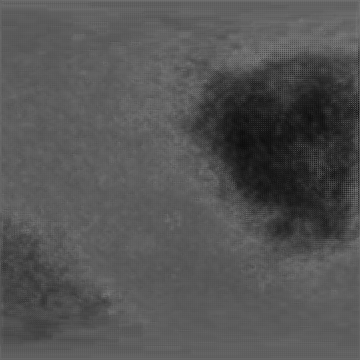

d1[0.696] d2[0.689] g[0.717]
110
d1[0.697] d2[0.688] g[0.717]
111
d1[0.697] d2[0.688] g[0.717]
112
d1[0.697] d2[0.688] g[0.717]
113
d1[0.697] d2[0.688] g[0.718]
114
d1[0.697] d2[0.687] g[0.718]
115
d1[0.698] d2[0.687] g[0.718]
116
d1[0.698] d2[0.687] g[0.718]
117
d1[0.698] d2[0.686] g[0.718]
118
d1[0.698] d2[0.686] g[0.719]
119


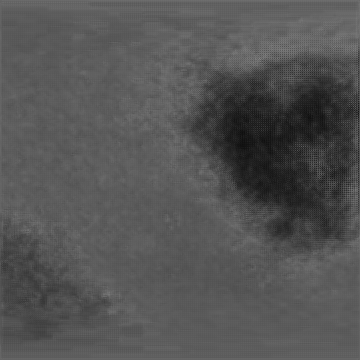

d1[0.699] d2[0.686] g[0.719]
120
d1[0.699] d2[0.686] g[0.719]
121
d1[0.699] d2[0.685] g[0.719]
122
d1[0.699] d2[0.685] g[0.719]
123
d1[0.699] d2[0.685] g[0.720]
124
d1[0.700] d2[0.684] g[0.720]
125
d1[0.700] d2[0.684] g[0.720]
126
d1[0.700] d2[0.684] g[0.720]
127
d1[0.701] d2[0.683] g[0.720]
128
d1[0.701] d2[0.683] g[0.721]
129


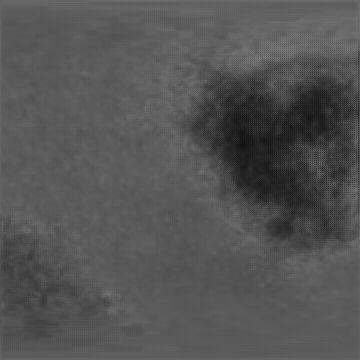

d1[0.701] d2[0.683] g[0.721]
130
d1[0.701] d2[0.682] g[0.721]
131
d1[0.702] d2[0.682] g[0.721]
132
d1[0.702] d2[0.682] g[0.722]
133
d1[0.702] d2[0.681] g[0.722]
134
d1[0.702] d2[0.681] g[0.722]
135
d1[0.703] d2[0.681] g[0.722]
136
d1[0.703] d2[0.680] g[0.723]
137
d1[0.703] d2[0.680] g[0.723]
138
d1[0.703] d2[0.680] g[0.723]
139


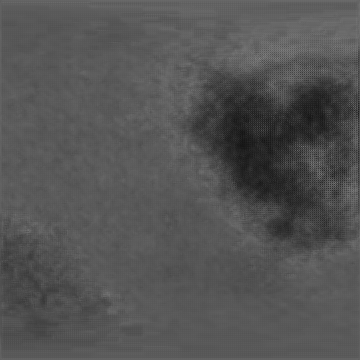

d1[0.704] d2[0.679] g[0.723]
140
d1[0.704] d2[0.679] g[0.723]
141
d1[0.704] d2[0.679] g[0.724]
142
d1[0.704] d2[0.678] g[0.724]
143
d1[0.705] d2[0.678] g[0.724]
144
d1[0.705] d2[0.678] g[0.724]
145
d1[0.705] d2[0.678] g[0.724]
146
d1[0.705] d2[0.677] g[0.725]
147
d1[0.706] d2[0.677] g[0.725]
148
d1[0.706] d2[0.677] g[0.725]
149


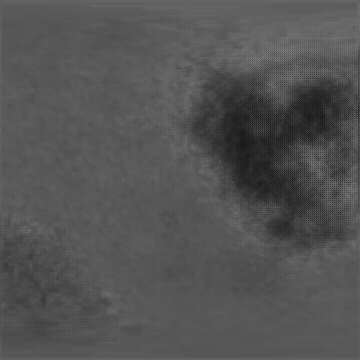

d1[0.706] d2[0.677] g[0.725]
150
d1[0.706] d2[0.676] g[0.726]
151
d1[0.707] d2[0.676] g[0.726]
152
d1[0.707] d2[0.676] g[0.726]
153
d1[0.707] d2[0.675] g[0.726]
154
d1[0.707] d2[0.675] g[0.726]
155
d1[0.707] d2[0.675] g[0.726]
156
d1[0.708] d2[0.675] g[0.727]
157
d1[0.708] d2[0.674] g[0.727]
158
d1[0.708] d2[0.674] g[0.727]
159


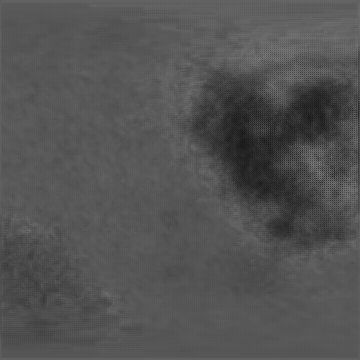

d1[0.708] d2[0.674] g[0.727]
160
d1[0.708] d2[0.674] g[0.727]
161
d1[0.709] d2[0.673] g[0.728]
162
d1[0.709] d2[0.673] g[0.728]
163
d1[0.709] d2[0.673] g[0.728]
164
d1[0.709] d2[0.673] g[0.728]
165
d1[0.709] d2[0.673] g[0.728]
166
d1[0.710] d2[0.672] g[0.728]
167
d1[0.710] d2[0.672] g[0.729]
168
d1[0.710] d2[0.672] g[0.729]
169


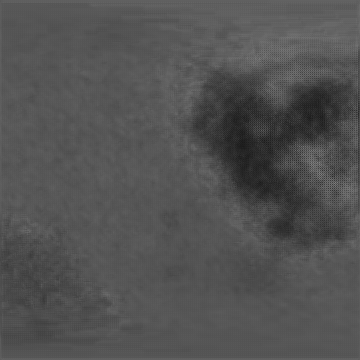

d1[0.710] d2[0.672] g[0.729]
170
d1[0.710] d2[0.672] g[0.729]
171
d1[0.711] d2[0.671] g[0.729]
172
d1[0.711] d2[0.671] g[0.729]
173
d1[0.711] d2[0.671] g[0.730]
174
d1[0.711] d2[0.671] g[0.730]
175
d1[0.711] d2[0.671] g[0.730]
176
d1[0.711] d2[0.671] g[0.730]
177
d1[0.712] d2[0.670] g[0.730]
178
d1[0.712] d2[0.670] g[0.730]
179


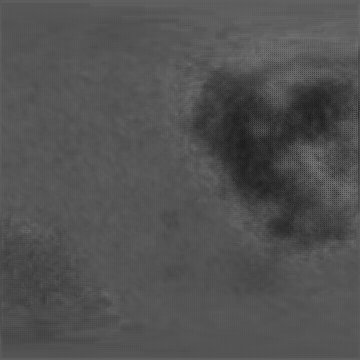

d1[0.712] d2[0.670] g[0.730]
180
d1[0.712] d2[0.670] g[0.731]
181
d1[0.712] d2[0.670] g[0.731]
182
d1[0.712] d2[0.670] g[0.731]
183
d1[0.713] d2[0.669] g[0.731]
184
d1[0.713] d2[0.669] g[0.731]
185
d1[0.713] d2[0.669] g[0.731]
186
d1[0.713] d2[0.669] g[0.731]
187
d1[0.713] d2[0.669] g[0.731]
188
d1[0.713] d2[0.669] g[0.732]
189


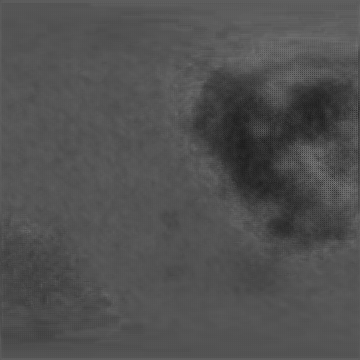

d1[0.714] d2[0.668] g[0.732]
190
d1[0.714] d2[0.668] g[0.732]
191
d1[0.714] d2[0.668] g[0.732]
192
d1[0.714] d2[0.668] g[0.732]
193
d1[0.714] d2[0.667] g[0.732]
194
d1[0.714] d2[0.667] g[0.733]
195
d1[0.715] d2[0.667] g[0.733]
196
d1[0.715] d2[0.666] g[0.733]
197
d1[0.715] d2[0.666] g[0.734]
198
d1[0.716] d2[0.666] g[0.734]
199


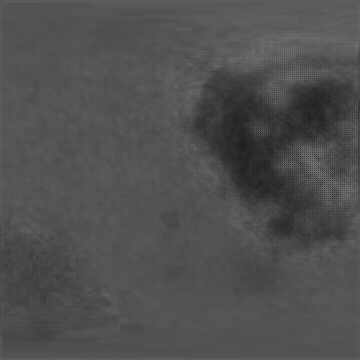

d1[0.716] d2[0.665] g[0.734]
200
d1[0.716] d2[0.665] g[0.734]
201
d1[0.717] d2[0.665] g[0.735]
202
d1[0.717] d2[0.665] g[0.735]
203
d1[0.717] d2[0.664] g[0.735]
204
d1[0.717] d2[0.664] g[0.735]
205
d1[0.717] d2[0.664] g[0.735]
206
d1[0.718] d2[0.664] g[0.735]
207
d1[0.718] d2[0.664] g[0.735]
208
d1[0.718] d2[0.664] g[0.736]
209


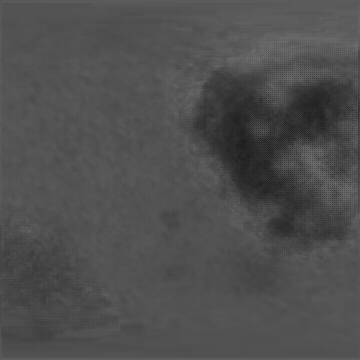

d1[0.718] d2[0.664] g[0.736]
210
d1[0.718] d2[0.664] g[0.736]
211
d1[0.718] d2[0.664] g[0.736]
212
d1[0.718] d2[0.664] g[0.736]
213
d1[0.718] d2[0.664] g[0.736]
214
d1[0.718] d2[0.664] g[0.736]
215
d1[0.718] d2[0.664] g[0.736]
216
d1[0.718] d2[0.664] g[0.736]
217
d1[0.718] d2[0.664] g[0.736]
218
d1[0.718] d2[0.664] g[0.736]
219


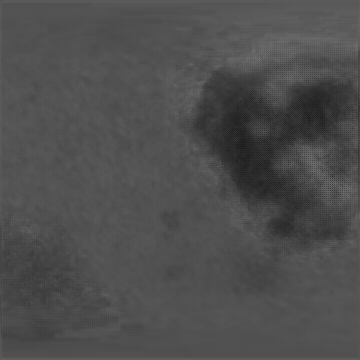

d1[0.718] d2[0.664] g[0.736]
220
d1[0.718] d2[0.664] g[0.736]
221
d1[0.718] d2[0.664] g[0.736]
222
d1[0.718] d2[0.664] g[0.735]
223
d1[0.718] d2[0.664] g[0.735]
224
d1[0.718] d2[0.665] g[0.735]
225
d1[0.718] d2[0.665] g[0.735]
226
d1[0.718] d2[0.665] g[0.735]
227
d1[0.718] d2[0.665] g[0.735]
228
d1[0.718] d2[0.665] g[0.735]
229


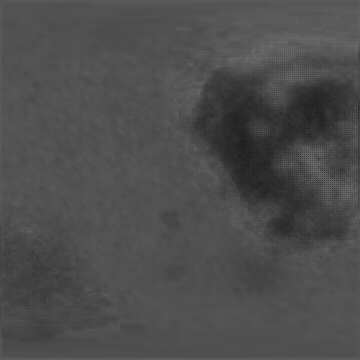

d1[0.718] d2[0.665] g[0.735]
230
d1[0.718] d2[0.665] g[0.735]
231
d1[0.718] d2[0.665] g[0.735]
232
d1[0.718] d2[0.665] g[0.735]
233
d1[0.718] d2[0.665] g[0.735]
234
d1[0.718] d2[0.665] g[0.735]
235
d1[0.718] d2[0.666] g[0.735]
236
d1[0.718] d2[0.666] g[0.735]
237
d1[0.718] d2[0.666] g[0.735]
238
d1[0.717] d2[0.666] g[0.735]
239


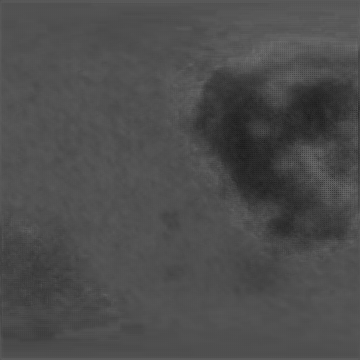

d1[0.717] d2[0.666] g[0.734]
240
d1[0.717] d2[0.666] g[0.734]
241
d1[0.717] d2[0.666] g[0.734]
242
d1[0.717] d2[0.666] g[0.734]
243
d1[0.717] d2[0.666] g[0.734]
244
d1[0.717] d2[0.667] g[0.734]
245
d1[0.717] d2[0.667] g[0.734]
246
d1[0.717] d2[0.667] g[0.734]
247
d1[0.717] d2[0.667] g[0.734]
248
d1[0.717] d2[0.667] g[0.734]
249


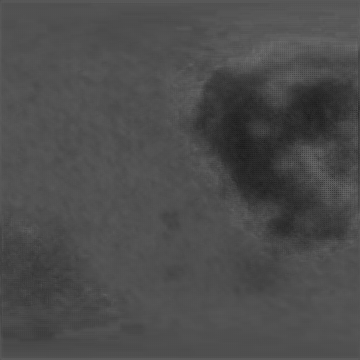

d1[0.717] d2[0.667] g[0.734]
250
d1[0.717] d2[0.667] g[0.733]
251
d1[0.717] d2[0.667] g[0.733]
252
d1[0.716] d2[0.668] g[0.733]
253


In [ ]:
X = X[:4]
def train(gen, dis, g, epochs=100, X = X, y = y):
  for i in range(epochs):
    print(i)
    dis_loss1 = dis.train_on_batch([y, y], np.ones((1,180,180,1)))
    dis_loss2 = dis.train_on_batch([y, gen.predict(X)], np.zeros((1,180,180,1)))
    X.append(y)    
    gan_loss, _, _ = g.train_on_batch(X, [np.ones((1,180,180,1)), y])
    X = X[:4]
    if (i+1) % 10 == 0:
      summarize_performance(i, gen, X)
    
    print('d1[%.3f] d2[%.3f] g[%.3f]' % (dis_loss1, dis_loss2, gan_loss))
train(gen,dis,g, 2500)

In [ ]:
model = modUnet((360,360,1))
model.compile(loss = "mse", optimizer = Adam(1e-2), metrics = ["mae"])

In [ ]:
model.fit(X, y, epochs = 1500, validation_data = (X_train, y_train))

Epoch 1/1500
1/1 [==============================] - 5s 5s/step - loss: 0.0972 - mae: 0.2725 - val_loss: 0.0907 - val_mae: 0.2973
Epoch 2/1500
1/1 [==============================] - 0s 108ms/step - loss: 0.0715 - mae: 0.2464 - val_loss: 0.0927 - val_mae: 0.2967
Epoch 3/1500
1/1 [==============================] - 0s 109ms/step - loss: 0.0438 - mae: 0.1961 - val_loss: 0.1911 - val_mae: 0.3979
Epoch 4/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0270 - mae: 0.1453 - val_loss: 0.1918 - val_mae: 0.3986
Epoch 5/1500
1/1 [==============================] - 0s 106ms/step - loss: 0.0201 - mae: 0.1032 - val_loss: 0.0917 - val_mae: 0.2985
Epoch 6/1500
1/1 [==============================] - 0s 105ms/step - loss: 0.0107 - mae: 0.0919 - val_loss: 0.0909 - val_mae: 0.2977
Epoch 7/1500
1/1 [==============================] - 0s 107ms/step - loss: 0.0076 - mae: 0.0768 - val_loss: 0.0909 - val_mae: 0.2977
Epoch 8/1500
1/1 [==============================] - 0s 104ms/step - loss: 0.004

In [ ]:
ans = gen.predict(X_train)

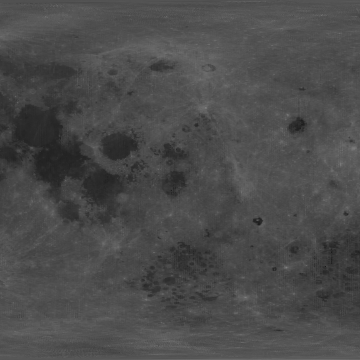

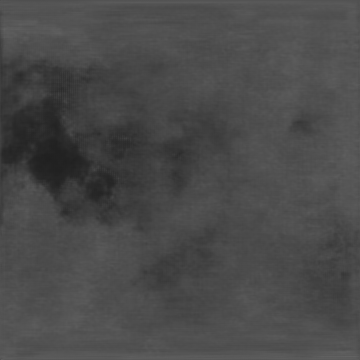

In [ ]:
cv2_imshow(np.squeeze(y_train)*255)
print(" ")
cv2_imshow(np.squeeze(ans)*255)

In [ ]:
X = X[:4]

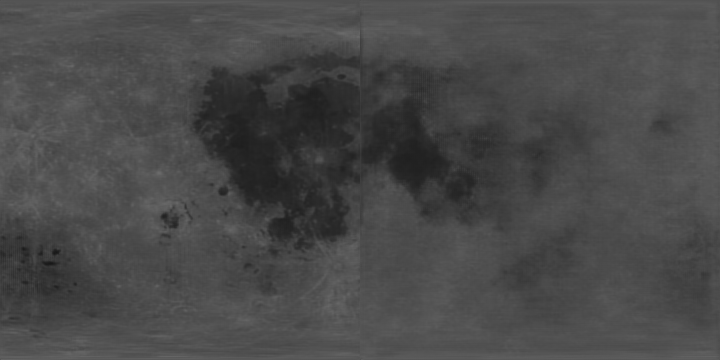

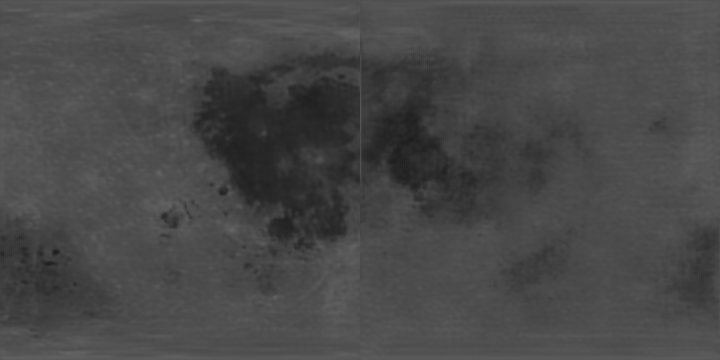

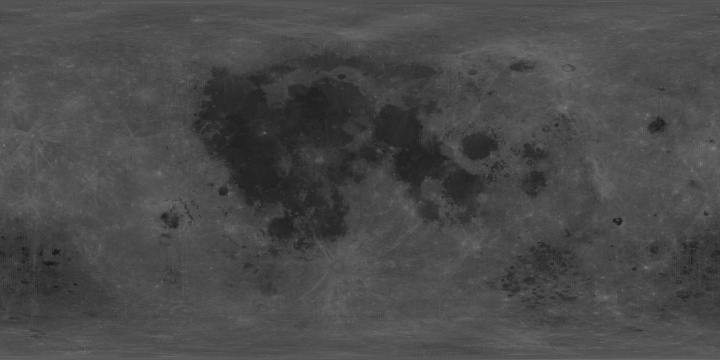

In [ ]:
x1 = np.concatenate([np.squeeze(gen.predict(X)), np.squeeze(gen.predict(X_train))], axis = -1)
cv2_imshow(x1*255)
print(" ")
x2 = np.concatenate([np.squeeze(model.predict(X)), np.squeeze(model.predict(X_train))], axis = -1)
cv2_imshow(x2*255)
print(" ")
cv2_imshow(albedo*255)

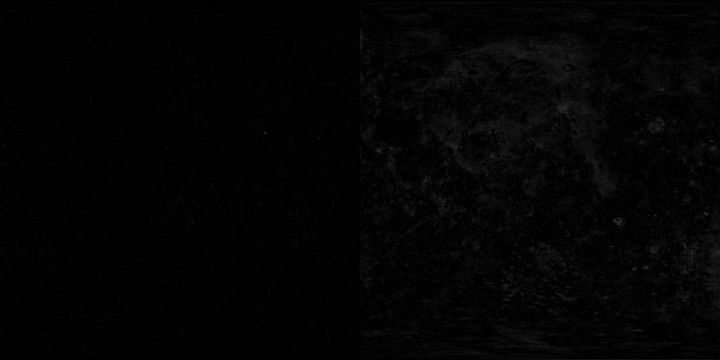

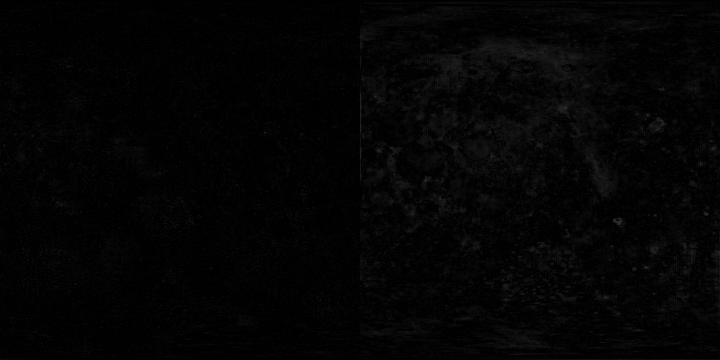

In [ ]:
cv2_imshow(abs(x1-albedo)*255)
print(" ")
cv2_imshow(abs(x2-albedo)*255)

In [ ]:
gen.save_weights("model1.h5")
model.save_weights("model2.h5")

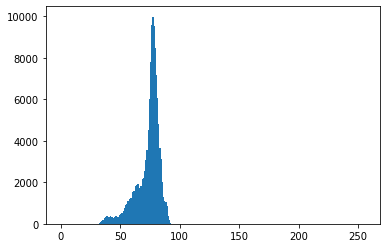

In [ ]:
import matplotlib.pyplot as plt

x1, x2 = np.squeeze(model.predict(X)), np.squeeze(model.predict(X_train))

plt.hist((x2*255).ravel(), 256, [0,256])
plt.show()